This notebook implements the training and evaluation pipeline for two novel,
lightweight architectures for cervical cancer analysis:
1.  MRF-DCN (Multi-Resolution Fusion Deep Convolutional Network): A lightweight classifier that processes images at multiple scales to achieve high accuracy with a very low parameter count.
2.  U-Net: A dedicated segmentation model trained on image patches to identify the precise boundaries of cells.

The pipeline includes:
-   Data loading for the Sipakmed dataset, specifically for this experiment.
-   A patch generation pipeline to create training data for the U-Net from
    whole slide images (WSIs) and their corresponding annotation files.
-   Separate, clear training loops for the classifier (MRF-DCN) and the
    segmenter (U-Net).
-   Dedicated evaluation functions for both classification (accuracy, reports)
    and segmentation (Dice score, visual inspection).


In [8]:
# --- Core Libraries ---
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from pathlib import Path
import shutil
from collections import defaultdict
import tqdm

# --- Keras and TensorFlow Components ---
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Concatenate, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast,
    GaussianNoise, RandomBrightness, # <--- THIS WAS ADDED
    Conv2D, MaxPooling2D, Flatten,
    Conv2DTranspose, BatchNormalization, Activation,
    GlobalAveragePooling2D, DepthwiseConv2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Scikit-learn Utilities ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# --- Google Colab Integration ---
from google.colab import drive
drive.mount('/content/drive')

# --- Environment Verification ---
print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print(" GPU is available and will be used for training.")
else:
    print(" GPU not available. Training will be significantly slower.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Version: 2.18.0
 GPU is available and will be used for training.


In [12]:
GDRIVE_PROJECT_PATH = Path('/content/drive/MyDrive/pap_project/data/raw/')
GDRIVE_SAVE_PATH = Path('/content/drive/MyDrive/ffUnet/')
GDRIVE_SAVE_PATH.mkdir(exist_ok=True)

# model params
IMG_SIZE = (224, 224)    # Input size for the classifier.
PATCH_SIZE = 512         # Input size for the segmentation U-Net.
BATCH_SIZE = 32          # Batch size for the classifier training.
SEG_BATCH_SIZE = 8       # Using a smaller batch size for the U-Net due to larger patch sizes.
EPOCHS = 75              # Max number of training epochs (early stopping is used).
SEED = 42                # Random seed for reproducibility.

# labels
LABEL_MAP = {'normal': 0, 'abnormal': 1}
CLASS_NAMES = ['Normal', 'Abnormal']

In [3]:
def load_sipakmed_for_classification(data_path, label_map):
    """
    Scans the Sipakmed dataset directories to find cropped cell images
    and their corresponding labels.

    Args:
        data_path (Path): The root directory of the Sipakmed dataset.
        label_map (dict): A dictionary to map string labels to integer IDs.

    Returns:
        pd.DataFrame: A DataFrame with 'filepath' and 'label_id' columns.
    """
    filepaths, labels = [], []
    print("Searching for cropped cell images...")

    for bmp_path in data_path.glob('im_*/**/*CROPPED*/*.bmp'):
        path_str = str(bmp_path)
        label = None

        # Determine the label based on the parent folder name.
        if 'im_Koilocytotic' in path_str or 'im_Dyskaryotic' in path_str:
            label = 'abnormal'
        elif 'im_Parabasal' in path_str or 'im_Superficial-Intermediate' in path_str or 'im_Metaplastic' in path_str:
            label = 'normal'

        if label:
            filepaths.append(path_str)
            labels.append(label)

    if not filepaths:
        print("No cropped images found. Check the `GDRIVE_PROJECT_PATH` and folder structure.")
        return pd.DataFrame()

    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    df['label_id'] = df['label'].map(label_map)
    return df

print("--- Preparing Data for Paper Replication (Sipakmed Only) ---")
sipakmed_df = load_sipakmed_for_classification(GDRIVE_PROJECT_PATH, LABEL_MAP)

# training, validation, and test splits (70/15/15 ratio)
train_val_df, test_df = train_test_split(
    sipakmed_df,
    test_size=0.15,
    random_state=SEED,
    stratify=sipakmed_df['label_id']
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1765,  # 0.15 / 0.85 ensures the validation set is 15% of the original total.
    random_state=SEED,
    stratify=train_val_df['label_id']
)

print(f"\nSuccessfully loaded and split {len(sipakmed_df)} cropped Sipakmed images.")
print(f"  -> Training Set:   {len(train_df)} images")
print(f"  -> Validation Set: {len(val_df)} images")
print(f"  -> Test Set:       {len(test_df)} images")

# Calculate class weights to handle data imbalance during training.
# This gives more importance to the minority class.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label_id']),
    y=train_df['label_id'].values
)
class_weight_dict = dict(enumerate(class_weights))
print(f"\nCalculated Class Weights for Training: {class_weight_dict}")

--- Preparing Data for Paper Replication (Sipakmed Only) ---
Searching for cropped cell images...

Successfully loaded and split 3236 cropped Sipakmed images.
  -> Training Set:   2264 images
  -> Validation Set: 486 images
  -> Test Set:       486 images

Calculated Class Weights for Training: {0: np.float64(0.6710136336692353), 1: np.float64(1.9618717504332757)}


In [4]:
PATCH_DIR = Path('/content/patches/')
PATCH_IMAGES_DIR = PATCH_DIR / 'images'
PATCH_MASKS_DIR = PATCH_DIR / 'masks'
PATCH_DF_PATH = PATCH_DIR / 'unet_patches.csv'
GDRIVE_PATCH_ZIP = GDRIVE_SAVE_PATH / 'patches.zip'

def parse_dats_to_mask(dat_paths, image_shape):
    """Converts .dat contour files into a single binary mask."""
    mask = np.zeros(image_shape, dtype=np.uint8)
    # Prioritize cytoplasm annotations if available, otherwise use nucleus.
    files_to_process = [p for p in dat_paths if 'cyt' in Path(p).name]
    if not files_to_process:
        files_to_process = [p for p in dat_paths if 'nuc' in Path(p).name]

    for dat_path in files_to_process:
        try:
            points = np.loadtxt(dat_path, delimiter=',', dtype=np.int32)
            if points.ndim == 2 and points.shape[1] == 2:
                cv2.drawContours(mask, [points], -1, 255, -1)
        except Exception:
            continue
    return mask

def generate_patches():
    """Extracts and saves patches from whole slide images and their masks."""
    print("--- Starting Patch Generation ---")
    PATCH_DIR.mkdir(exist_ok=True)
    PATCH_IMAGES_DIR.mkdir(exist_ok=True)
    PATCH_MASKS_DIR.mkdir(exist_ok=True)

    # Find all whole slide images and map them to their .dat annotation files.
    wsi_data_map = defaultdict(list)
    for dat_path in GDRIVE_PROJECT_PATH.glob('im_*/**/*.dat'):
        base_name = dat_path.name.split('_')[0]
        # The main image is NOT in a CROPPED folder / WIF
        bmp_path = dat_path.parent / f'{base_name}.bmp'
        if bmp_path.exists() and 'CROPPED' not in str(bmp_path):
             wsi_data_map[str(bmp_path)].append(str(dat_path))

    patch_data = []
    patch_counter = 0
    stride = PATCH_SIZE // 2  # 50% overlap between patches

    for img_path_str, dat_paths in tqdm.tqdm(wsi_data_map.items(), desc="Processing WSIs"):
        full_img = cv2.imread(img_path_str)
        if full_img is None:
            continue
        h, w, _ = full_img.shape
        full_mask = parse_dats_to_mask(dat_paths, (h, w))

        for y in range(0, h - PATCH_SIZE + 1, stride):
            for x in range(0, w - PATCH_SIZE + 1, stride):
                img_patch = full_img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                mask_patch = full_mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

                # Keep only patches with significant mask content to avoid empty background.
                if np.mean(mask_patch) < 2.0: # (threshold is ~0.8% of pixels)
                    continue

                # Save the patch and its mask locally.
                img_patch_path = PATCH_IMAGES_DIR / f'patch_{patch_counter}.png'
                mask_patch_path = PATCH_MASKS_DIR / f'patch_{patch_counter}.png'
                cv2.imwrite(str(img_patch_path), img_patch)
                cv2.imwrite(str(mask_patch_path), mask_patch)
                patch_data.append({'image_path': str(img_patch_path), 'mask_path': str(mask_patch_path)})
                patch_counter += 1

    print(f"\n Patch generation complete. Generated {patch_counter} valid patches.")
    patch_df = pd.DataFrame(patch_data)
    patch_df.to_csv(PATCH_DF_PATH, index=False)
    print(f"Patch dataframe saved to {PATCH_DF_PATH}")
    return patch_df

if GDRIVE_PATCH_ZIP.exists():
    print(f"Found existing patch archive at '{GDRIVE_PATCH_ZIP}'.")
    print("Unzipping... this may take a moment.")
    shutil.unpack_archive(GDRIVE_PATCH_ZIP, '/content/', format='zip')
    print(" Successfully unzipped patches.")
    unet_patch_df = pd.read_csv(PATCH_DF_PATH)
    print(f"Loaded patch dataframe with {len(unet_patch_df)} entries.")
else:
    print("No pre-generated patch archive found. Starting generation process...")
    if any(GDRIVE_PROJECT_PATH.glob('im_*/**/*.dat')):
        unet_patch_df = generate_patches()
        # After generation, zip the results and save to Drive for future runs.
        print("\nZipping generated patches for future use...")
        shutil.make_archive(str(GDRIVE_PATCH_ZIP).replace('.zip',''), 'zip', PATCH_DIR)
        print(f" Patches archived to '{GDRIVE_PATCH_ZIP}'.")
    else:
        print(" No .dat files found for patch generation. Skipping U-Net sections.")
        unet_patch_df = pd.DataFrame() # Create empty df to avoid errors later

No pre-generated patch archive found. Starting generation process...
--- Starting Patch Generation ---


Processing WSIs:   0%|          | 1/966 [00:04<1:08:18,  4.25s/it]<ipython-input-4-2264668620>:18: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  points = np.loadtxt(dat_path, delimiter=',', dtype=np.int32)
Processing WSIs: 100%|██████████| 966/966 [1:26:13<00:00,  5.36s/it]



 Patch generation complete. Generated 11910 valid patches.
Patch dataframe saved to /content/patches/unet_patches.csv

Zipping generated patches for future use...
 Patches archived to '/content/drive/MyDrive/Cervical_Cancer_Classification_Project_Final/patches.zip'.


In [9]:
# Data Augmentation

data_augmentation_layer = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.4),
    RandomZoom(0.3),
    RandomContrast(0.3),
    RandomBrightness(factor=0.2),
    GaussianNoise(stddev=0.1)
], name="data_augmentation")

def apply_color_preprocessing(image):
    """
    Applies advanced color and contrast enhancements using OpenCV.
    This helps to normalize the images and highlight cellular features.
    """

    img_np = image.numpy().astype(np.uint8)
    # Bilateral filter
    img_filtered = cv2.bilateralFilter(img_np, d=9, sigmaColor=75, sigmaSpace=75)
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab = cv2.cvtColor(img_filtered, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    return tf.convert_to_tensor(img_enhanced, dtype=tf.float32)

@tf.function
def tf_color_preprocessing_wrapper(image, label):
    """
    A TensorFlow Function wrapper to integrate the OpenCV preprocessing
    into the main `tf.data` pipeline.
    """
    processed_image, = tf.py_function(
        func=lambda img: [apply_color_preprocessing(img)],
        inp=[image],
        Tout=[tf.float32]
    )
    processed_image.set_shape([*IMG_SIZE, 3])
    return processed_image, label

def create_classifier_dataset(df, augment=False, batch_size=BATCH_SIZE):
    """Creates a tf.data.Dataset for the classification task."""
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label_id'].values))
    # Load and resize images
    dataset = dataset.map(lambda fp, lbl: (tf.image.resize(tf.io.decode_bmp(tf.io.read_file(fp), 3), IMG_SIZE), lbl),
                          num_parallel_calls=tf.data.AUTOTUNE)
    # Apply advanced color preprocessing
    dataset = dataset.map(tf_color_preprocessing_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    # Apply data augmentation if it's the training set
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation_layer(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

def create_segmentation_dataset(df, shuffle=False, batch_size=SEG_BATCH_SIZE):
    """Creates a tf.data.Dataset for the segmentation task."""
    def load_patch_and_mask(img_path, mask_path):
        img = tf.io.decode_png(tf.io.read_file(img_path), channels=3)
        mask = tf.io.decode_png(tf.io.read_file(mask_path), channels=1)
        # Normalize pixels to the [0, 1] range.
        img = tf.cast(img, tf.float32) / 255.0
        mask = tf.cast(mask, tf.float32) / 255.0
        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['mask_path'].values))
    dataset = dataset.map(load_patch_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), seed=SEED)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print(" Data pipeline functions are ready.")

 Data pipeline functions are ready.


In [10]:
def separable_conv_block(x, filters, name_prefix):
    # A depthwise separable convolution block for efficiency.
    x = DepthwiseConv2D((3, 3), activation='relu', padding='same', name=f'{name_prefix}_dw_conv')(x)
    x = BatchNormalization(name=f'{name_prefix}_dw_bn')(x)
    x = Conv2D(filters, (1, 1), activation='relu', padding='same', name=f'{name_prefix}_pw_conv')(x)
    x = BatchNormalization(name=f'{name_prefix}_pw_bn')(x)
    return x

def build_mrf_dcn_classifier(input_shape=IMG_SIZE + (3,), num_classes=1):
    """
    Builds the Multi-Resolution Fusion Deep Convolutional Network (MRF-DCN)
    based on the lightweight design from the paper. It uses parallel branches
    to process the image at different resolutions (128, 64, 32) and fuses
    the results for a final prediction.
    """
    main_input = Input(shape=input_shape, name="main_input")

    def feature_extractor_branch(x, name_prefix):
        # Two separable convolution blocks followed by pooling
        x = separable_conv_block(x, filters=32, name_prefix=f'{name_prefix}_sepconv1')
        x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool1')(x)
        x = separable_conv_block(x, filters=64, name_prefix=f'{name_prefix}_sepconv2')
        x = MaxPooling2D((2, 2), name=f'{name_prefix}_pool2')(x)
        # Global Average Pooling creates a feature vector from the spatial map,
        # dramatically reducing parameters compared to a Flatten layer.
        x = GlobalAveragePooling2D(name=f'{name_prefix}_gap')(x)
        x = Dense(64, activation='relu', name=f'{name_prefix}_dense')(x)
        return x

    # Parallel training in branches
    features_128 = feature_extractor_branch(Resizing(128, 128)(main_input), 'branch128')
    features_64 = feature_extractor_branch(Resizing(64, 64)(main_input), 'branch64')
    features_32 = feature_extractor_branch(Resizing(32, 32)(main_input), 'branch32')

    # Fusion stages
    concatenated = Concatenate()([features_128, features_64, features_32])
    fused = Dense(64, activation='relu')(concatenated)
    fused = Dropout(0.5)(fused) # Dropout for regularization

    # Output Layer
    # Sigmoid activation for binary classification
    output = Dense(num_classes, activation='sigmoid', name="classification_output")(fused)
    model = Model(inputs=main_input, outputs=output, name="Lightweight_MRF_DCN")
    return model

def build_unet_segmenter(input_shape=(PATCH_SIZE, PATCH_SIZE, 3)):
    """
    Builds a standard U-Net for semantic segmentation of cell patches.
    It follows the classic encoder-decoder structure with skip connections.
    """

    def conv_block(tensor, filters):
        x = Conv2D(filters, 3, padding="same", activation="relu")(tensor)
        x = Conv2D(filters, 3, padding="same", activation="relu")(x)
        return x

    inputs = Input(shape=input_shape)

    # --- Encoder ---
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D(2)(c1)
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D(2)(c2)
    c3 = conv_block(p2, 64)
    p3 = MaxPooling2D(2)(c3)
    c4 = conv_block(p3, 128)
    p4 = MaxPooling2D(2)(c4)

    # --- Bottleneck ---
    bn = conv_block(p4, 256)

    # --- Decoder ---
    d1 = Conv2DTranspose(128, 2, strides=2, padding="same")(bn)
    d1 = Concatenate()([d1, c4])
    d1 = conv_block(d1, 128)
    d2 = Conv2DTranspose(64, 2, strides=2, padding="same")(d1)
    d2 = Concatenate()([d2, c3])
    d2 = conv_block(d2, 64)
    d3 = Conv2DTranspose(32, 2, strides=2, padding="same")(d2)
    d3 = Concatenate()([d3, c2])
    d3 = conv_block(d3, 32)
    d4 = Conv2DTranspose(16, 2, strides=2, padding="same")(d3)
    d4 = Concatenate()([d4, c1])
    d4 = conv_block(d4, 16)

    # --- Output Layer ---
    # 1x1 convolution with sigmoid for a single-channel, binary mask
    outputs = Conv2D(1, 1, activation='sigmoid')(d4)
    model = Model(inputs, outputs, name="UNet_Segmenter")
    return model


print("--- Lightweight MRF-DCN Classifier Architecture ---")
mrf_dcn_model = build_mrf_dcn_classifier()
mrf_dcn_model.summary()

print("\n--- U-Net Segmenter Architecture ---")
unet_model = build_unet_segmenter()
unet_model.summary()

--- Lightweight MRF-DCN Classifier Architecture ---


Model: "Lightweight_MRF_DCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 128, 128,  │          0 │ main_input[0][0]  │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_1          │ (None, 64, 64, 3) │          0 │ main_input[0][0]  │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_2          │ (None, 32, 32, 3) │          0 │ main_input[0][0]  │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch128_sepconv1… │ (None, 128, 128,  │         30 │ resizing[0][0]    │
│ (DepthwiseConv2D)   │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch64_sepconv1_… │ (None, 64, 64, 3) │         30 │ resizing_1[0][0]  │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch32_sepconv1_… │ (None, 32, 32, 3) │         30 │ resizing_2[0][0]  │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch128_sepconv1… │ (None, 128, 128,  │         12 │ branch128_sepcon… │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch64_sepconv1_… │ (None, 64, 64, 3) │         12 │ branch64_sepconv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch32_sepconv1_… │ (None, 32, 32, 3) │         12 │ branch32_sepconv… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch128_sepconv1… │ (None, 128, 128,  │        128 │ branch128_sepcon… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch64_sepconv1_… │ (None, 64, 64,    │        128 │ branch64_sepconv… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch32_sepconv1_… │ (None, 32, 32,    │        128 │ branch32_sepconv… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch128_sepconv1… │ (None, 128, 128,  │        128 │ branch128_sepcon… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch64_sepconv1_… │ (None, 64, 64,    │        128 │ branch64_sepconv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch32_sepconv1_… │ (None, 32, 32,    │        128 │ branch32_sepconv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ branch128_pool1     │ (None, 64, 64,    │          0 │ branch128_sepcon

 Total params: 34,239 (133.75 KB)

 Trainable params: 33,453 (130.68 KB)

 Non-trainable params: 786 (3.07 KB)


--- U-Net Segmenter Architecture ---


Model: "UNet_Segmenter"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
CLASSIFIER_MODEL_PATH = GDRIVE_SAVE_PATH / 'classifier_model.keras'
SEGMENTER_MODEL_PATH = GDRIVE_SAVE_PATH / 'segmentation_model.keras'

print("\n" + "="*50)
print("--- Pipeline: Classifier (MRF-DCN) ---")
print("="*50)

if not CLASSIFIER_MODEL_PATH.exists():
    print("No pre-trained classifier found. Starting training...")
    # Prepare the datasets
    train_ds_cls = create_classifier_dataset(train_df, augment=True)
    val_ds_cls = create_classifier_dataset(val_df)

    # build the model
    classifier = build_mrf_dcn_classifier()
    classifier.compile(
        optimizer=Adam(learning_rate=0.001), # best in my experience
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Callbacks to save the best model and stop early if validation loss stagnates
    checkpoint = ModelCheckpoint(str(CLASSIFIER_MODEL_PATH), monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Start training
    classifier.fit(
        train_ds_cls,
        epochs=EPOCHS,
        validation_data=val_ds_cls,
        callbacks=[checkpoint, early_stop],
        class_weight=class_weight_dict
    )
    print(f" Training complete. Best model saved to {CLASSIFIER_MODEL_PATH}")
else:
    print(f" Found pre-trained classifier at '{CLASSIFIER_MODEL_PATH}'. Skipping training.")


# train unet
print("\n" + "="*50)
print("--- Pipeline: Segmenter (U-Net) ---")
print("="*50)

def dice_loss(y_true, y_pred, smooth=1e-6):
    """The Dice coefficient loss function."""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

if not unet_patch_df.empty:
    if not SEGMENTER_MODEL_PATH.exists():
        print("No pre-trained segmenter found. Starting training...")

        train_unet_df, val_unet_df = train_test_split(unet_patch_df, test_size=0.2, random_state=SEED)
        train_ds_seg = create_segmentation_dataset(train_unet_df, shuffle=True)
        val_ds_seg = create_segmentation_dataset(val_unet_df)


        segmenter = build_unet_segmenter()
        segmenter.compile(optimizer=Adam(1e-4), loss=dice_loss, metrics=['accuracy'])

        # Callbacks
        checkpoint = ModelCheckpoint(str(SEGMENTER_MODEL_PATH), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Start training
        segmenter.fit(
            train_ds_seg,
            epochs=EPOCHS,
            validation_data=val_ds_seg,
            callbacks=[checkpoint, early_stop]
        )
        print(f" Training complete. Best model saved to {SEGMENTER_MODEL_PATH}")
    else:
        print(f" Found pre-trained segmenter at '{SEGMENTER_MODEL_PATH}'. Skipping training.")
else:
    print(" SKIPPING U-NET TRAINING: No patch data was generated or loaded.")


--- Pipeline: Classifier (MRF-DCN) ---
 Found pre-trained classifier at '/content/drive/MyDrive/ffUnet/classifier_model.keras'. Skipping training.

--- Pipeline: Segmenter (U-Net) ---
 Found pre-trained segmenter at '/content/drive/MyDrive/ffUnet/segmentation_model.keras'. Skipping training.



--- Evaluating Classifier: classifier_model.keras ---

[1] Quantitative Performance:
  - Test Accuracy: 0.9321
  - Test Loss:     0.1590
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step

[2] Classification Report:
              precision    recall  f1-score   support

      Normal     0.9532    0.9558    0.9545       362
    Abnormal     0.8699    0.8629    0.8664       124

    accuracy                         0.9321       486
   macro avg     0.9115    0.9094    0.9104       486
weighted avg     0.9319    0.9321    0.9320       486

[3] Confusion Matrix:


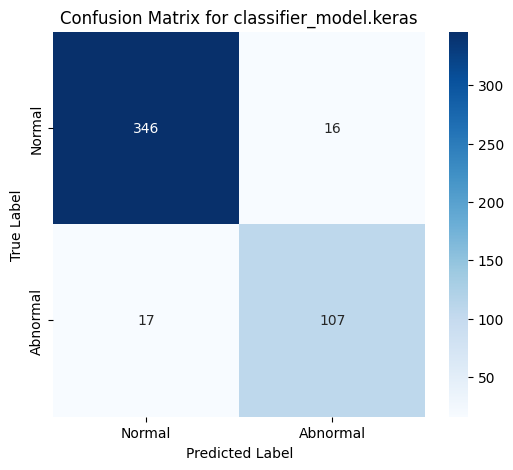


--- Evaluating Segmenter: segmentation_model.keras ---

[1] Quantitative Performance:


Calculating Dice Score: 100%|██████████| 298/298 [00:39<00:00,  7.58it/s]


  - Average Dice Score on Test Set: 0.8996

[2] Visualizing 5 Test Predictions:


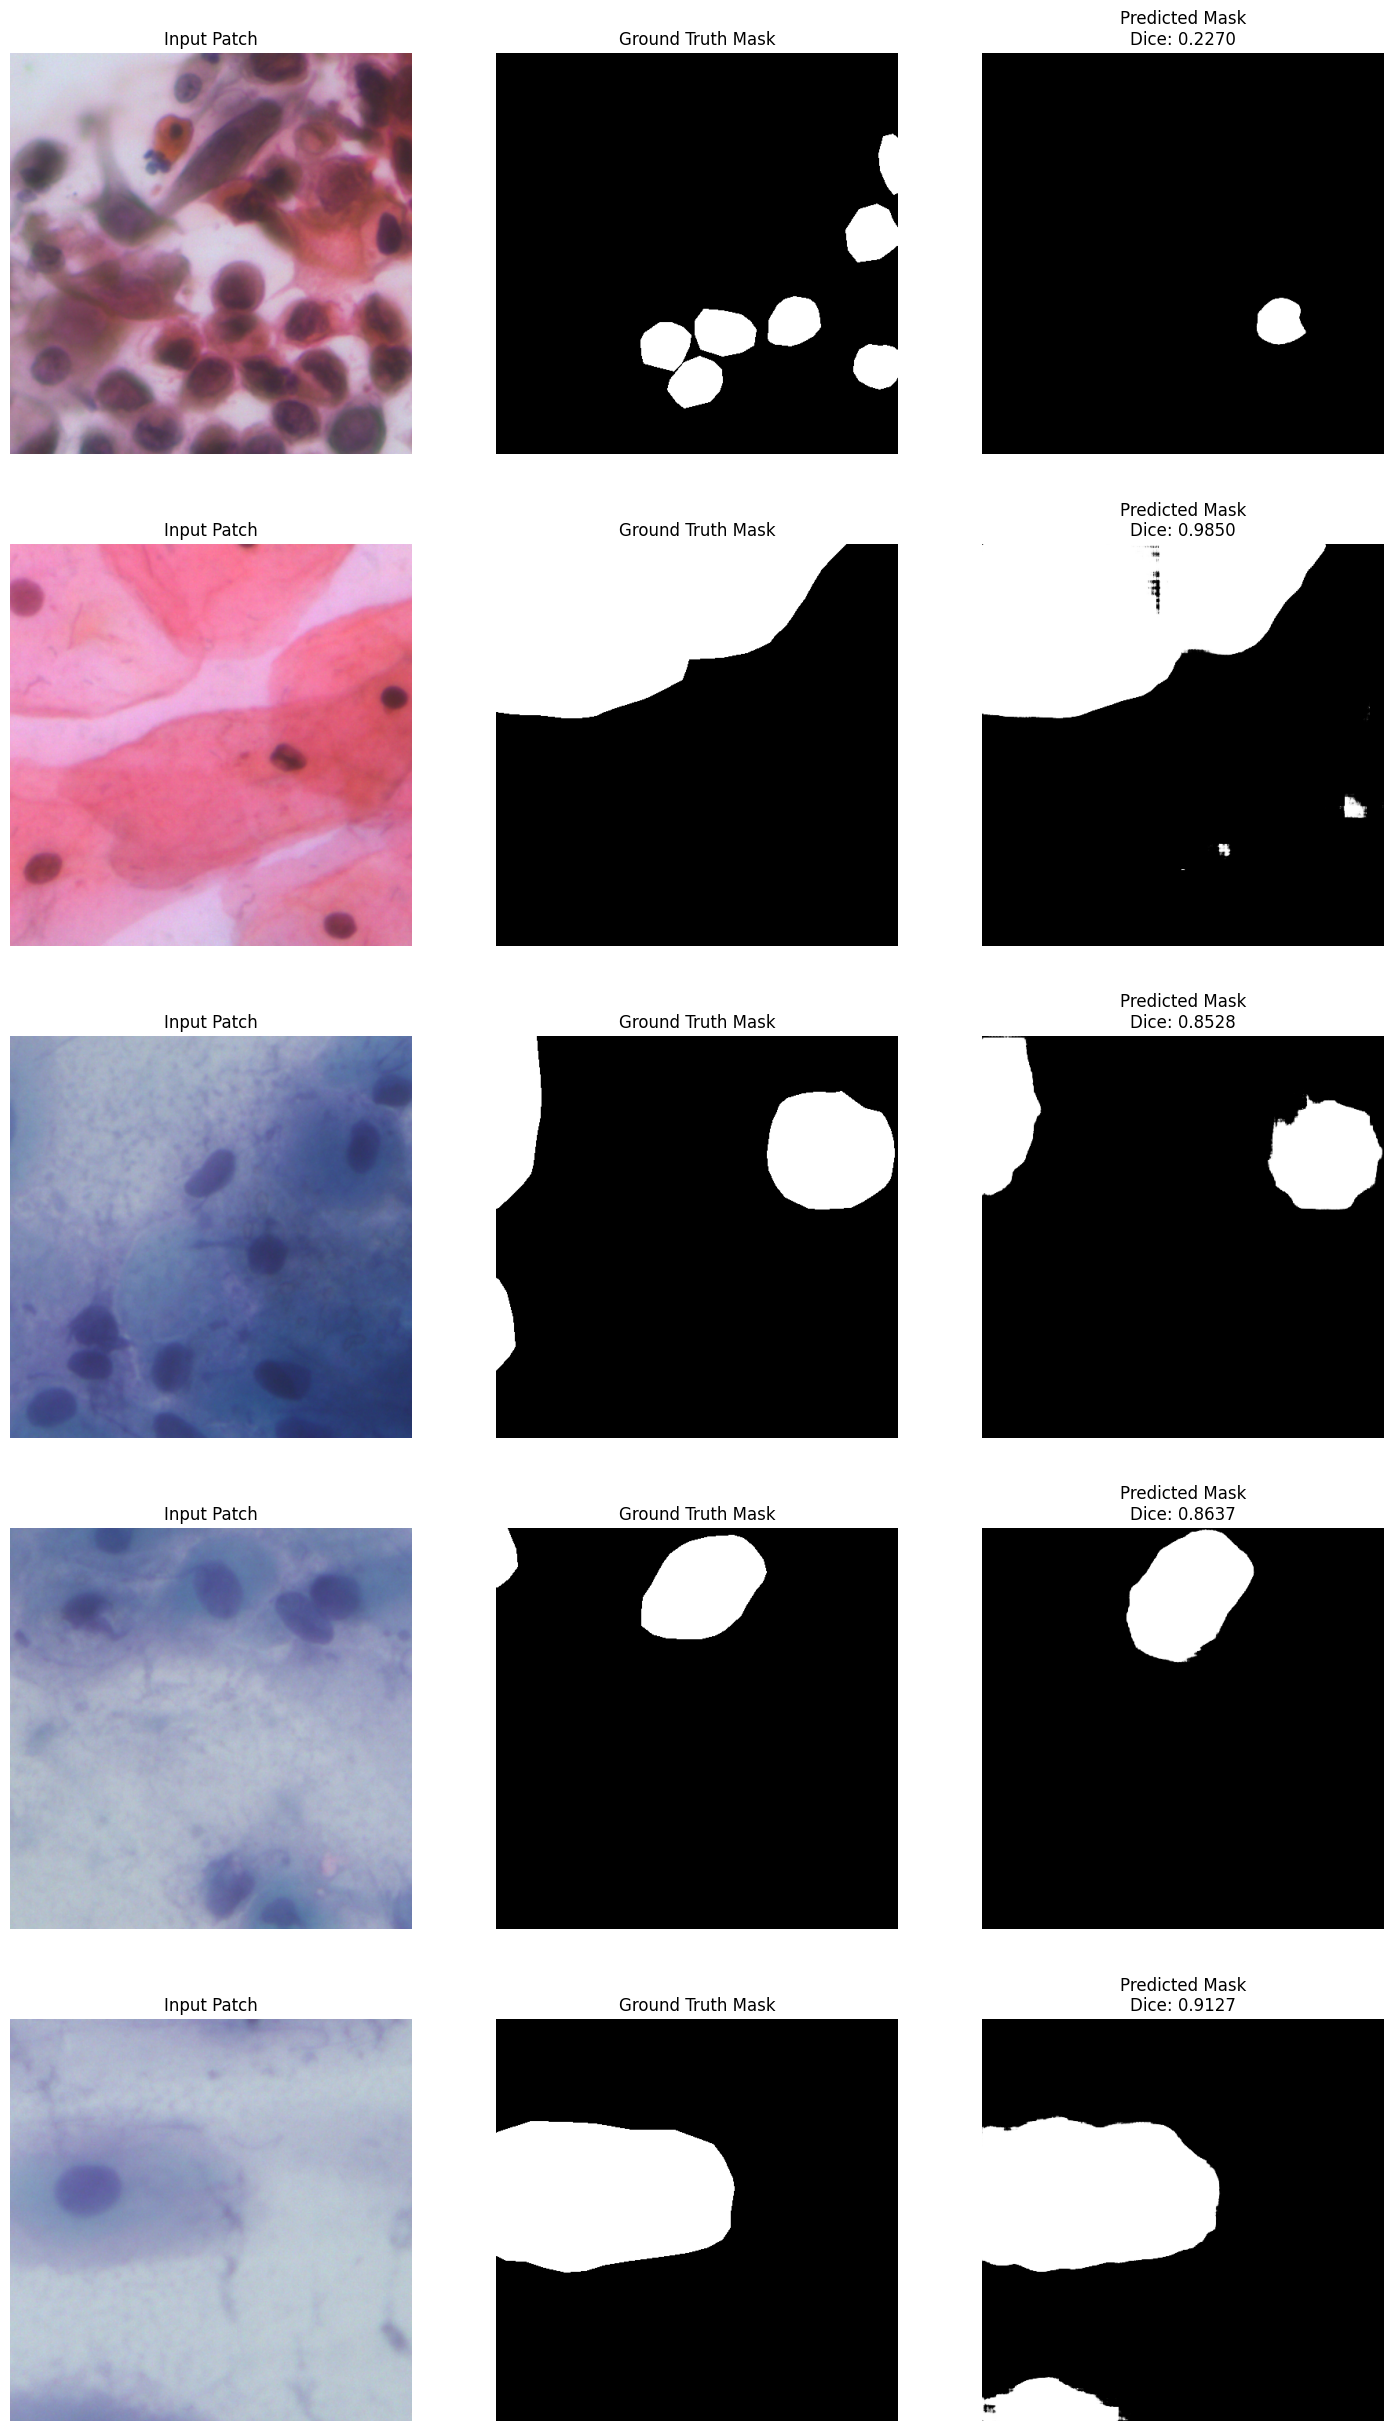


  ALL EVALUATIONS COMPLETE


In [14]:
def evaluate_classifier(model_path, test_dataframe):
    """
    Loads a trained classifier and evaluates its performance on the test set.
    """
    print("\n" + "="*50)
    print(f"--- Evaluating Classifier: {model_path.name} ---")
    print("="*50)

    if not model_path.exists():
        print("!!! SKIPPING: Model file not found. !!!")
        return

    # Load the model and prepare the test dataset
    model = load_model(str(model_path))
    test_ds = create_classifier_dataset(test_dataframe)


    print("\n[1] Quantitative Performance:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"  - Test Accuracy: {accuracy:.4f}")
    print(f"  - Test Loss:     {loss:.4f}")


    y_true = np.concatenate([y for _, y in test_ds]).flatten()
    y_pred_proba = model.predict(test_ds).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)


    print("\n[2] Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))


    print("[3] Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix for {model_path.name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def evaluate_segmenter(model_path, patch_dataframe, num_examples=5):
    """
    Loads a trained segmenter and evaluates its performance on test patches.
    """
    print("\n" + "="*50)
    print(f"--- Evaluating Segmenter: {model_path.name} ---")
    print("="*50)

    if not model_path.exists():
        print("!!! SKIPPING: Model file not found. !!!")
        return

    def dice_score(y_true, y_pred, smooth=1e-6):
        y_true_f = tf.cast(tf.keras.backend.flatten(y_true), tf.float32)
        y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), tf.float32)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

    model = load_model(str(model_path), custom_objects={'dice_loss': dice_loss})
    _, test_patch_df = train_test_split(patch_dataframe, test_size=0.2, random_state=SEED+1)
    test_ds_seg = create_segmentation_dataset(test_patch_df)

    # Average dice score
    print("\n[1] Quantitative Performance:")
    all_scores = [dice_score(m, model.predict(i, verbose=0)) for i, m in tqdm.tqdm(test_ds_seg, desc="Calculating Dice Score")]
    print(f"  - Average Dice Score on Test Set: {np.mean(all_scores):.4f}")

    # Visual eval
    print(f"\n[2] Visualizing {num_examples} Test Predictions:")
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))
    fig.tight_layout(pad=3.0)

    for i, (img_patch, true_mask) in enumerate(test_ds_seg.unbatch().take(num_examples)):
        pred_mask = model.predict(tf.expand_dims(img_patch, 0), verbose=0)[0]
        score = dice_score(true_mask, pred_mask).numpy()

        axes[i, 0].imshow(img_patch)
        axes[i, 0].set_title("Input Patch")
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask\nDice: {score:.4f}")
        for ax in axes[i]: ax.axis('off')
    plt.show()


evaluate_classifier(CLASSIFIER_MODEL_PATH, test_df)

if not unet_patch_df.empty:
    evaluate_segmenter(SEGMENTER_MODEL_PATH, unet_patch_df)
else:
    print("\n SKIPPING Segmenter Evaluation: No patch data was available.")

print("\n" + "="*80 + "\n  ALL EVALUATIONS COMPLETE\n" + "="*80)